# Salsa CMU dataset

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np
from models.KalmanVAE import KalmanVAE
from matplotlib import pyplot as plt

In [3]:
files = sorted(os.listdir('data/salsa_mocap/'))
print(files[20])

FileNotFoundError: [Errno 2] No such file or directory: 'data/salsa_mocap/'

In [3]:
kvae = KalmanVAE(input_dim=41*3, hidden_dim=256, obs_dim=64, 
                     latent_dim=64, num_modes=3, beta=1, alpha='rnn').float().cpu()
print(kvae)
checkpoint = torch.load('/data2/users/cb221/stored_models_KVAE_salsa/salsa_warmup_temperature_0.5_200_warmup_latest.pth.tar')
kvae.load_state_dict(checkpoint['kvae'])
kvae.R = kvae.R.cpu()
kvae.Q = kvae.Q.cpu()
kvae.Sigma_1 = kvae.Sigma_1.cpu()
kvae.mu_1 = kvae.mu_1.cpu()

KalmanVAE(
  (encoder): MLP(
    (fc1): Linear(in_features=123, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): MLP(
    (fc1): Linear(in_features=64, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=123, bias=True)
  )
  (parameter_net): LSTM(64, 256, num_layers=2, batch_first=True)
  (alpha_out): Linear(in_features=256, out_features=3, bias=True)
)


In [4]:
obs = torch.from_numpy(np.load("new_salsa_data_preprocessed.npy")).float().cpu()
dl = TensorDataset(obs)
train_loader = DataLoader(dl, batch_size=30, shuffle=False)

In [5]:
with torch.no_grad():
    kvae.gamma=0.5
    input = next(iter(train_loader))[0]
    gamma = kvae.get_alpha_from_obs(input.cpu(), variational=True).reshape(30,200,-1)

In [6]:
files_starting_point = [260, 240, 240, 240, 280, 140, 120, 260, 380, 300, 240, 240, 240, 160, 240, 260, 260, 240, 240, 280, 140, 120, 260, 380, 300, 240, 240, 240, 160, 260]
start = files_starting_point[0]
states = gamma[2].argmax(-1)
l = list(range(0 + start,200*4 + start,4))
for i in range(1,200):
    if states[i] != states[i-1]:
        print(l[i])


496
556
676
756
948
980
1052


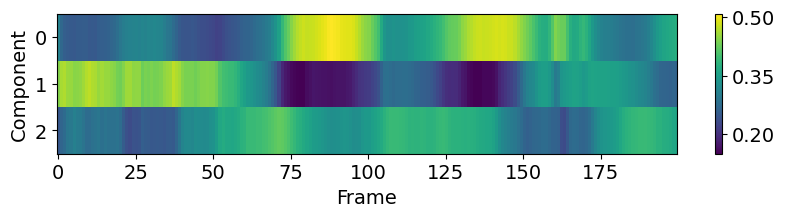

In [14]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,4))
plt.subplot(211)
cax = plt.imshow(gamma[2,:].cpu().detach().numpy().T, aspect='auto')
plt.xlabel('Frame')
plt.ylabel('Component')
plt.colorbar(cax, ticks=[0, 0.2,0.35, 0.5, 0.75])